In [1]:
from eval import (
    load_eval_data,
    plot_best_mae_box,
    plot_best_mae_over_time,
    plot_mae_over_time,
    plot_steps_to_convergence_box,
    plot_steps_to_threshold_box,
)


In [2]:
data = load_eval_data("bo_rl_opponent_evaluation")


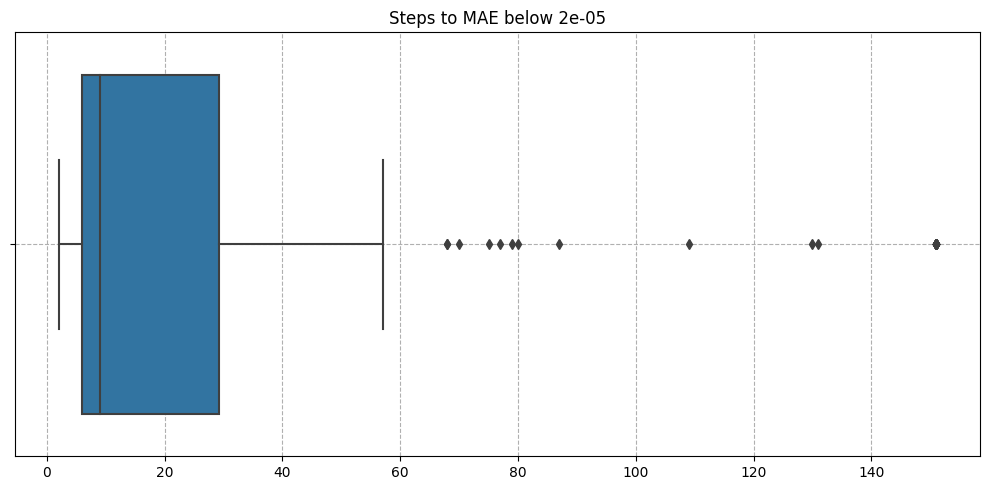

In [3]:
plot_steps_to_threshold_box(data)


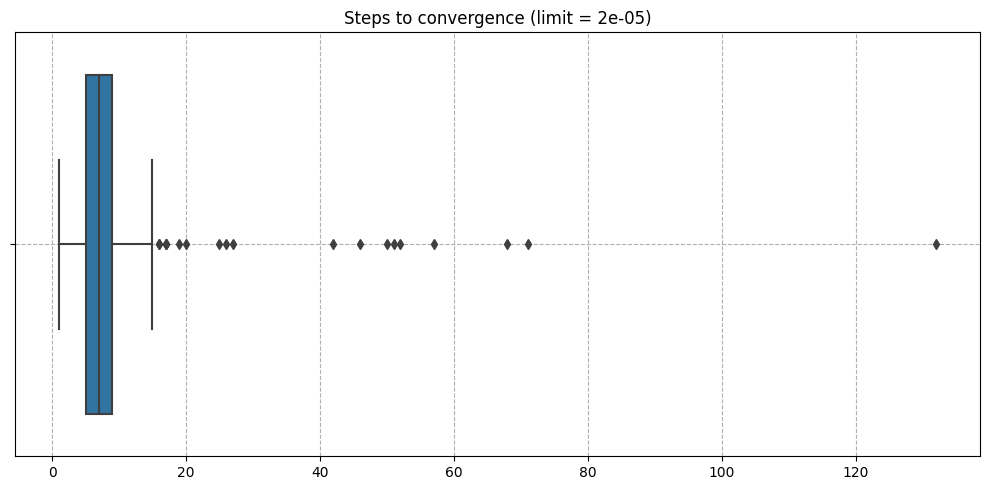

In [4]:
plot_steps_to_convergence_box(data)


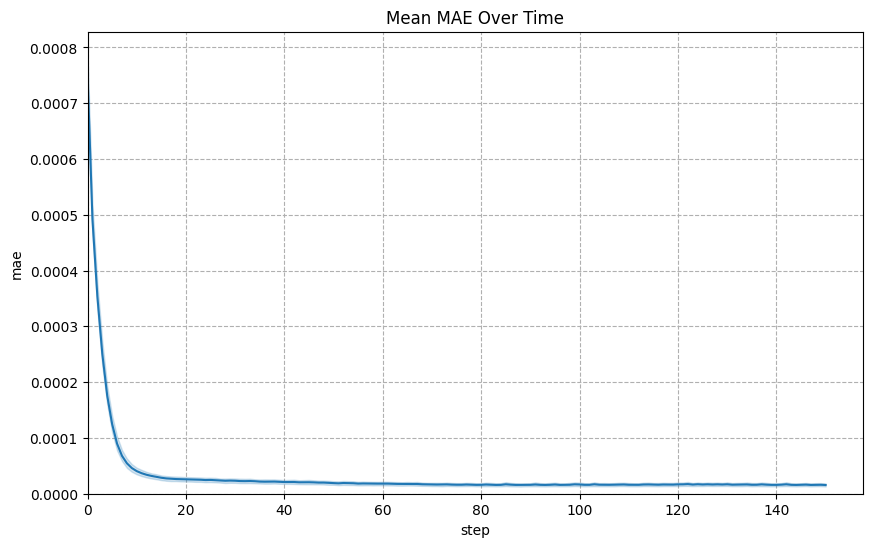

In [5]:
plot_mae_over_time(data)


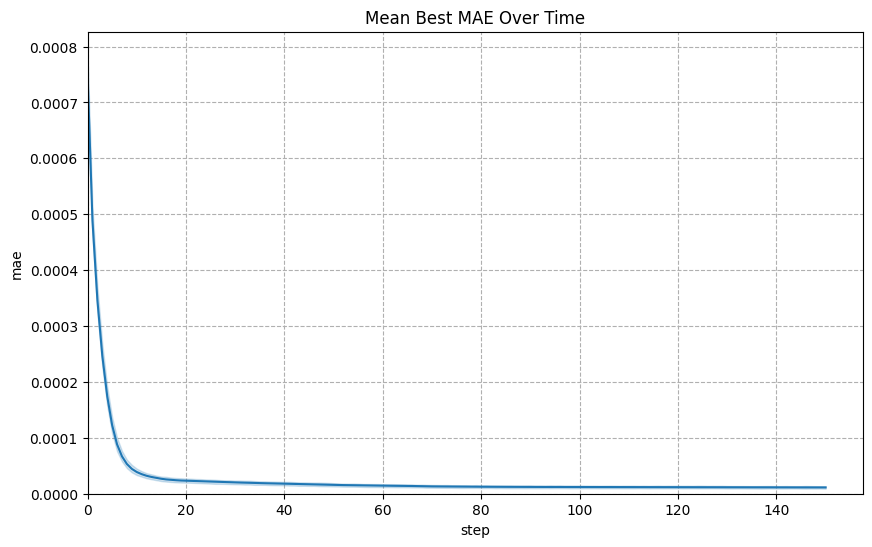

In [6]:
plot_best_mae_over_time(data)


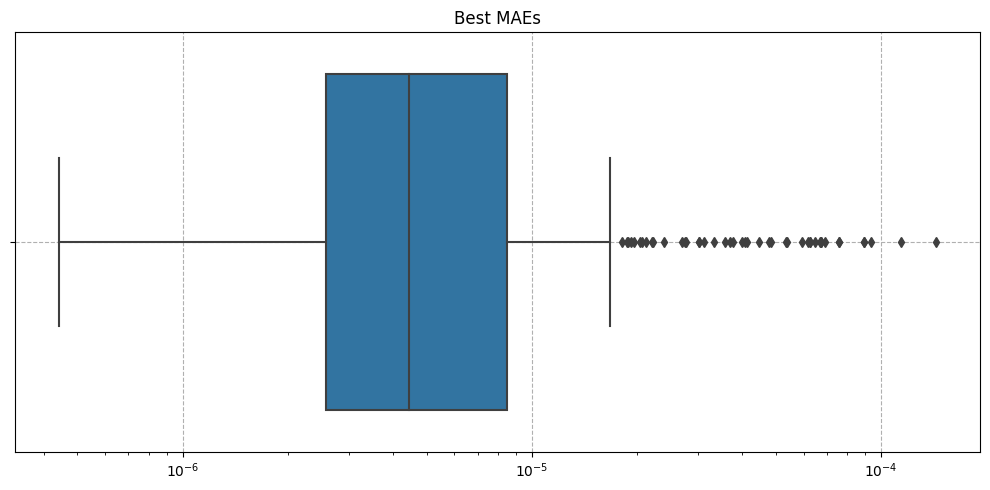

In [7]:
plot_best_mae_box(data)
